In [3]:
import matplotlib.pyplot as plt
import matplotlib_inline
import pandas as pd
from matplotlib.pyplot import plot, show
from seaborn import heatmap
from tqdm import tqdm
import warnings
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import StratifiedKFold
import json
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# 导入数据

In [4]:
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
warnings.filterwarnings('ignore')
DATA_PATH = 'data/'
train = pd.read_csv(DATA_PATH + 'train_dataset.csv', sep='\t')

# 对数据进行整合与平整

In [5]:
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
warnings.filterwarnings('ignore')
DATA_PATH = 'data/'
train = pd.read_csv(DATA_PATH + 'train_dataset.csv', sep='\t')

# 解决数据不平衡，采用上采样
ros = RandomOverSampler(random_state=0)
train, train['risk_label'] = ros.fit_resample(train, train['risk_label'])

test = pd.read_csv(DATA_PATH + 'test_dataset.csv', sep='\t')
data = pd.concat([train, test])

# 细化特征

In [6]:
# 从session_id中读取秒数并存储
data['ii'] = data['session_id'].apply(lambda x: int(x[-7:-5]))

# 从location中读取其中三个属性并存储
data['location_first_lvl'] = data['location'].astype(str).apply(lambda x: json.loads(x)['first_lvl'])
data['location_sec_lvl'] = data['location'].astype(str).apply(lambda x: json.loads(x)['sec_lvl'])
data['location_third_lvl'] = data['location'].astype(str).apply(lambda x: json.loads(x)['third_lvl'])

# 丢弃无用的两个特征
data.drop(['client_type', 'browser_source'], axis=1, inplace=True)

# 默认账密验证
data['auth_type'].fillna('1', inplace=True)

# 标签编码

In [7]:
# 对文本特征标签编码
for col in tqdm(['user_name', 'action', 'auth_type', 'ip',
                 'ip_location_type_keyword', 'ip_risk_level', 'location', 'device_model',
                 'os_type', 'os_version', 'browser_type', 'browser_version',
                 'bus_system_code', 'op_target', 'location_first_lvl', 'location_sec_lvl',
                 'location_third_lvl']):
    lbl = LabelEncoder()
    data[col] = lbl.fit_transform(data[col])

100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 253.68it/s]


# 细化时间特征

In [8]:
data['op_date'] = pd.to_datetime(data['op_date'])

# 获取操作具体时间
data['year'] = data['op_date'].dt.year
data['month'] = data['op_date'].dt.month
data['day'] = data['op_date'].dt.day
data['hour'] = data['op_date'].dt.hour

# 获取操作时间戳
data['op_ts'] = data["op_date"].values.astype(np.int64) // 10 ** 9

# 根据用户和操作时间戳排序，并计算每个用户的操作时间差
data = data.sort_values(by=['user_name', 'op_ts']).reset_index(drop=True)
data['last_ts'] = data.groupby(['user_name'])['op_ts'].shift(1)
data['ts_diff1'] = data['op_ts'] - data['last_ts']

print(data['op_ts'].dtype)

int64


dtype('float64')

# 构建特征

In [9]:
# 特征构建
for f in ['ip', 'location', 'device_model', 'os_version', 'browser_version']:
    data[f'user_{f}_nunique'] = data.groupby(['user_name'])[f].transform('nunique')
for method in ['mean', 'max', 'min', 'std', 'sum', 'median']:
    for col in ['user_name', 'ip', 'location', 'device_model', 'os_version', 'browser_version']:
        data[f'ts_diff1_{method}_' + str(col)] = data.groupby(col)['ts_diff1'].transform(method)

group_list = ['user_name','ip', 'location', 'device_model', 'os_version', 'browser_version', 'op_target']

num_feature_list = ['ts_diff1']
for group in group_list:
    for feature in num_feature_list:
        tmp = data.groupby(group)[feature].agg([sum, min, max, np.mean]).reset_index()
        tmp = pd.merge(data, tmp, on=group, how='left')
        data['{}-mean_gb_{}'.format(feature, group)] = data[feature] - tmp['mean']
        data['{}-min_gb_{}'.format(feature, group)] = data[feature] - tmp['min']
        data['{}-max_gb_{}'.format(feature, group)] = data[feature] - tmp['max']
        data['{}/sum_gb_{}'.format(feature, group)] = data[feature] / tmp['sum']

# 挑选出分类特征
cat_cols = ['action', 'auth_type', 'browser_type',
            'browser_version', 'bus_system_code', 'device_model',
            'ip', 'ip_location_type_keyword', 'ip_risk_level', 'location', 'op_target',
            'os_type', 'os_version', 'user_name'
            ]

# 画出特征之间的协方差热力图

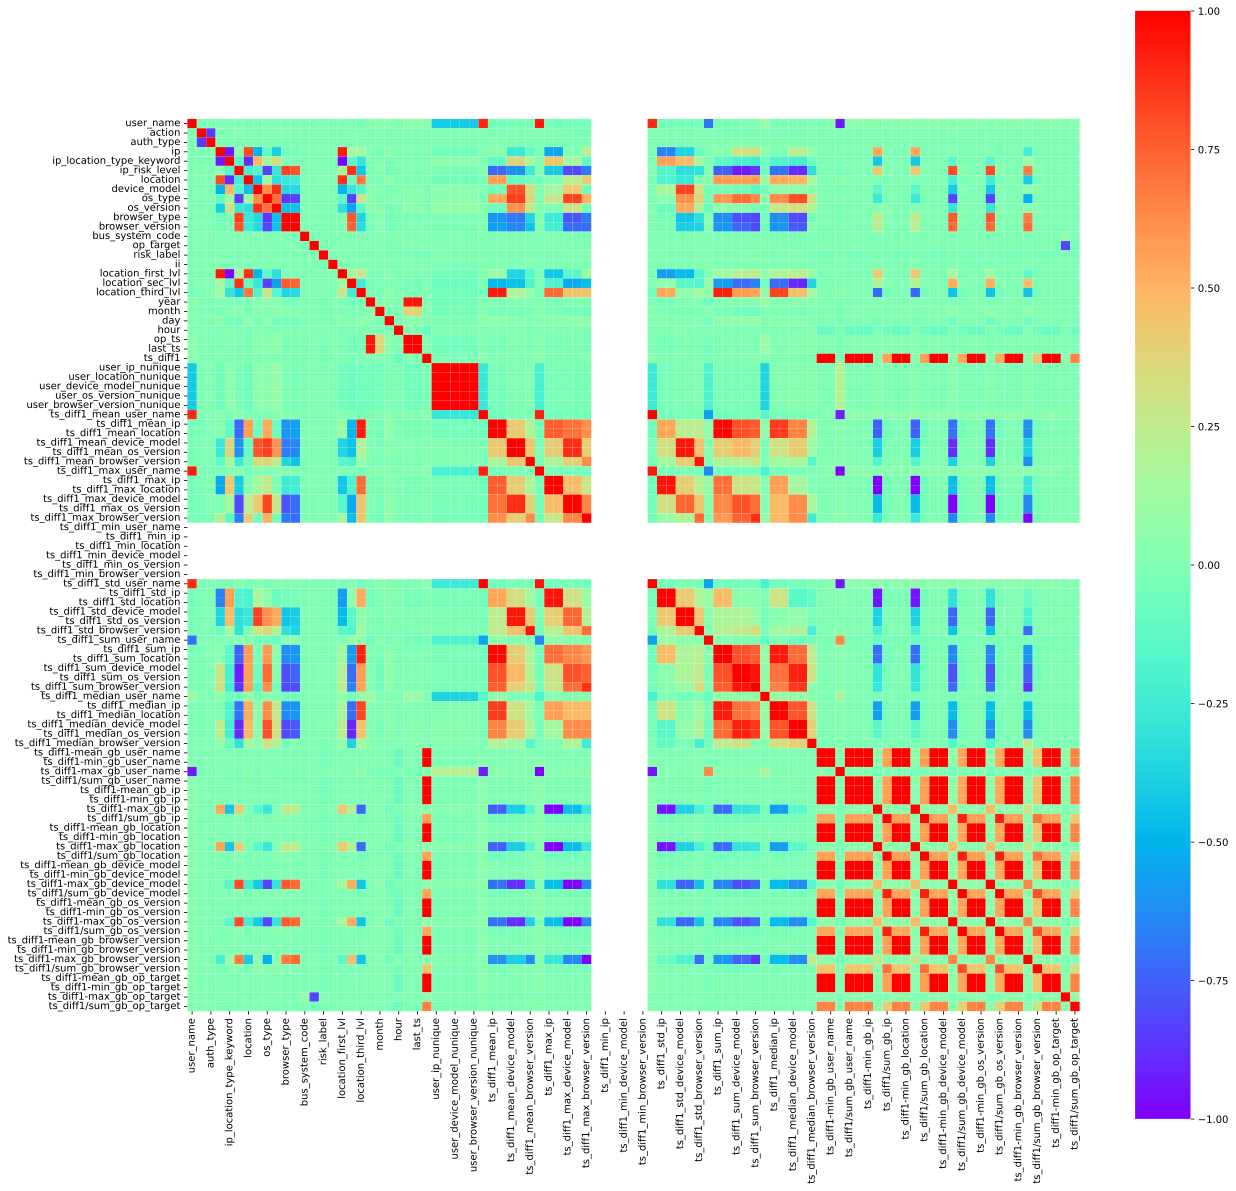

In [10]:
plt.figure(figsize=(20,20))
heatmap(data.corr(), cmap='rainbow', square=True)
plt.show()

# 分离训练集与测试集

In [11]:
train = data[~data['risk_label'].isna()].reset_index(drop=True)
test = data[data['risk_label'].isna()].reset_index(drop=True)

# 初始化与调参

In [12]:
# 挑选训练特征(session_id等特征均已经被缩放因此不再需要，risk_label作为目标标签)
features = [i for i in train.columns if i not in ['risk_label', 'session_id', 'op_date', 'last_ts']]
# 选出训练集中的目标标签
y = train['risk_label']

# 定义为5折验证
Fold = 5

# 初始化n折交叉验证器
KF = StratifiedKFold(n_splits=Fold, random_state=2022, shuffle=True)

# 调参
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'learning_rate': 0.05,
    'num_leaves': 2 ** 6,
    'max_depth': 8,
    'tree_learner': 'serial',
    'colsample_bytree': 0.8,
    'subsample_freq': 1,
    'subsample': 0.8,
    'num_boost_round': 5000,
    'max_bin': 255,
    'verbose': -1,
    'seed': 2021,
    'bagging_seed': 2021,
    'feature_fraction_seed': 2021,
    'early_stopping_rounds': 100,
}

# 使用n折交叉验证划分数据集（此处n取10）训练模型并进行预测

In [13]:
# 初始化预测值和oof
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros((len(test)))

# 采用n折交叉验证划分数据集，y为训练集中的目标标签risk_label,划分好的n-1折在训练集trn_idx,1折在验证集val_idx，均是去掉目标标签的训练集的一部分
for fold_, (trn_idx, val_idx) in enumerate(KF.split(train.values, y.values)):
    print("fold n°{}".format(fold_))
    # 获取用于训练的训练集和测试集，第一个参数为特征矩阵，第二个数参是对应标签，即训练集、验证集每个样本对应的risk_label
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=y.iloc[val_idx])
    num_round = 3000
    clf = lgb.train(
        params,
        trn_data,
        num_round,
        valid_sets=[trn_data, val_data],
        verbose_eval=100,
        early_stopping_rounds=50,
        categorical_feature=cat_cols
    )

    # 计算oof(折外预测)数组(训练集中的每一组样本都会有一次作为验证集的机会，因此每次的val_idx均不同且总和为训练集大小，因此oof数组保存了每一折计算的结果)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    # 对测试集预测 由于是将5次交叉验证的值进行相加取平均，因此在最后应除以5(每次除以5再相加与先相加再除以5是一样的)
    predictions_lgb[:] += clf.predict(test[features], num_iteration=clf.best_iteration) / Fold

fold n°0
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.967104	valid_1's auc: 0.882172
Early stopping, best iteration is:
[14]	training's auc: 0.936125	valid_1's auc: 0.884316
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.969774	valid_1's auc: 0.883124
[200]	training's auc: 0.986786	valid_1's auc: 0.884006
[300]	training's auc: 0.995294	valid_1's auc: 0.885204
[400]	training's auc: 0.998197	valid_1's auc: 0.884866
Early stopping, best iteration is:
[337]	training's auc: 0.996681	valid_1's auc: 0.885256
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.965154	valid_1's auc: 0.878651
Early stopping, best iteration is:
[2]	training's auc: 0.910045	valid_1's auc: 0.88236
fold n°3
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.969651	valid_1's auc: 0.881459
Early stopping, best iteration is:
[29]	training's auc: 0.946443	

# 模型评测

In [14]:
print("AUC score: {}".format(roc_auc_score(y, oof_lgb)))
print("F1 score: {}".format(f1_score(y, [1 if i >= 0.5 else 0 for i in oof_lgb])))
print("Precision score: {}".format(precision_score(y, [1 if i >= 0.5 else 0 for i in oof_lgb])))
print("Recall score: {}".format(recall_score(y, [1 if i >= 0.5 else 0 for i in oof_lgb])))

AUC score: 0.8805189346241608
F1 score: 0.8606094808126411
Precision score: 0.9958641706573792
Recall score: 0.7577012255713812


# 保存结果

In [15]:
test['ret'] = predictions_lgb
test['id'] = range(1, 10001)
test[['id', 'ret']].to_csv('ans/sub_5225.csv', index=False)
test['ret'].sum()

3239.9992665638274